# Fitting a mixture model to Praesepe

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [203]:
# line model
def line(theta, x):
    return np.polyval(theta, x)

# likelihood fn
def lnlike(theta, x, y, yerr):
    Y, V, P, V1 = theta[0], theta[1], theta[2], theta[3]
    pars = theta[4:]
    
    model1 = line(pars, x)
    model2 = Y
    inv_var1 = 1./(V1 + yerr**2)
    inv_var2 = 1./(V + yerr**2)
    lnlike1 =  - 0.5 * ((y-model1)**2*inv_var1 - np.log(inv_var1))
    lnlike2 =  - 0.5 * ((y-model2)**2*inv_var2 - np.log(inv_var2))
    ll = np.sum(np.logaddexp(np.log(1-P) + lnlike1, np.log(P) + lnlike2))

    if P > 0 and P < 1 and V > 0 and V1 > 0:
        return ll
    else:
        return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

<ErrorbarContainer object of 3 artists>

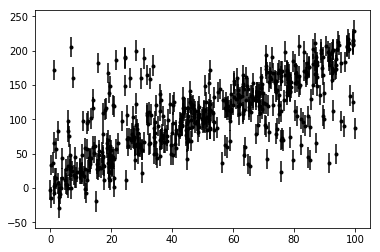

In [204]:
Yb_true, Vb_true, Pb_true, V1_true, m_true, b_true = 100, 2000, .3, 100, 2, 5,

x = np.random.uniform(0, 100, 500)
err = 15
y = b_true + m_true*x
yerr = np.ones_like(y)*err

probs = np.random.uniform(0, 1, len(x))
outlier_mask = probs < Pb_true

y[outlier_mask] = Yb_true + np.random.randn(len(y[outlier_mask]))*np.sqrt(Vb_true)
y[~outlier_mask] += np.random.randn(len(y[~outlier_mask]))*np.sqrt(V1_true + err**2)

plt.errorbar(x, y, yerr=yerr, fmt = 'k.')

In [205]:
# Yb, Vb, Pb, V1, m, b
theta_init = [100., 2000., .3, 10, 2., 5.]

# Calculate maximum-likelihood values
nll = lambda *args: -lnlike(*args)
result = sco.minimize(nll, theta_init, args=(x, y, yerr))

print("Yb", result.x[0], Yb_true)
print("Vb", result.x[1], Vb_true)
print("Pb", result.x[2], Pb_true)
print("V1", result.x[3], V1_true)
print("m", result.x[4], m_true)
print("b", result.x[5], b_true)

Yb 105.95347209324188 100
Vb 1622.2455951712627 2000
Pb 0.3109418933337573 0.3
V1 60.22984165650373 100
m 2.024685900992701 2
b 3.3157375433331966 5


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


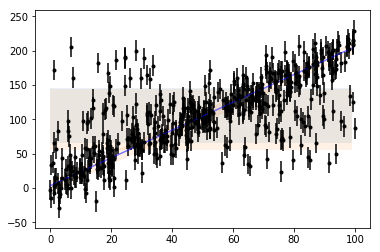

In [206]:
xp = np.arange(min(x), max(x), 1.)

# Yb, Vb, Pb, V1, m, b
mean = line(result.x[4:], xp)
var = np.sqrt(result.x[1])
var1 = np.sqrt(result.x[3])
Yb = result.x[0]

plt.errorbar(x, y, yerr=yerr, fmt = 'k.')

plt.plot(xp, mean, "b-", alpha=0.5)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")

plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)
plt.fill_between(xp, Yb_true - np.sqrt(Vb_true), Yb_true + np.sqrt(Vb_true), alpha=.1)

In [207]:
# Run emcee
import emcee
import corner

ndim, nwalkers = len(result.x), 32
pos = [result.x + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, yerr));
print("Burn-in")
pos, lp, state = sampler.run_mcmc(pos, 1000);
sampler.reset();
print("Full Run")
sampler.run_mcmc(pos, 5000);

Burn-in
Full Run


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


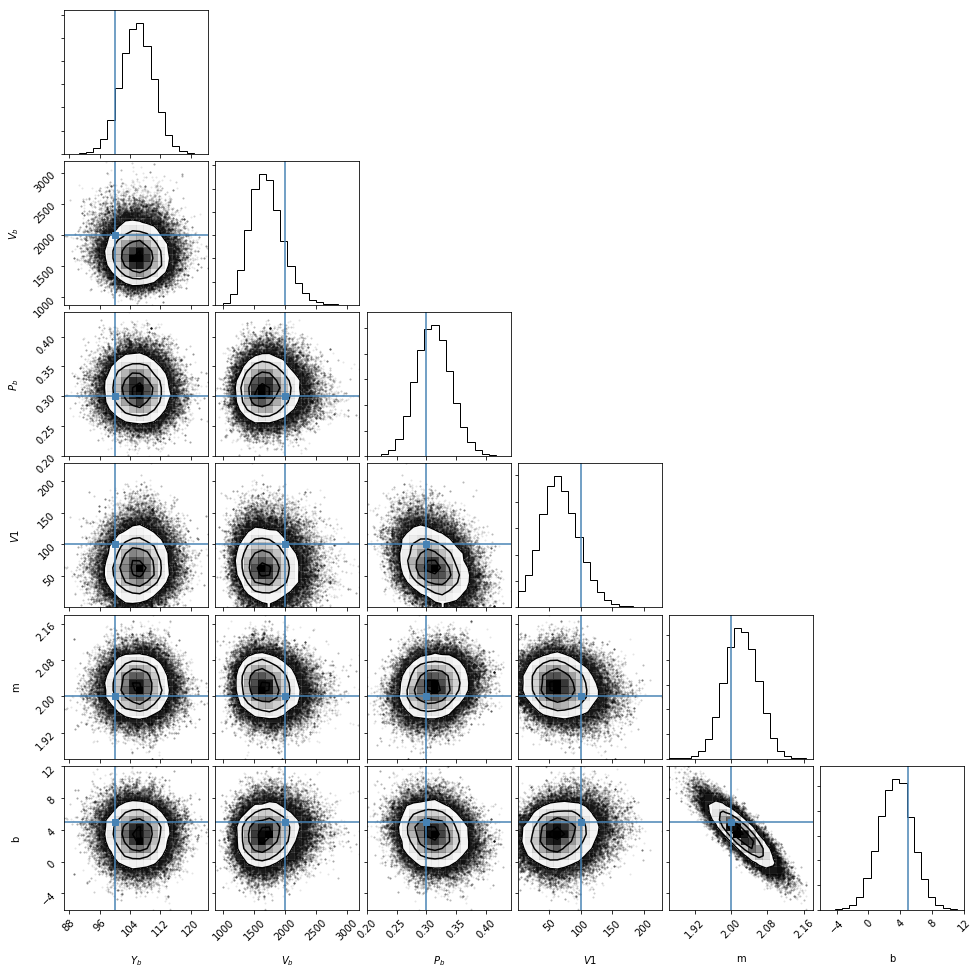

In [208]:
# Flatten chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# Make triangle plot
fig_labels = ["$Y_b$", "$V_b$", "$P_b$", "$V1$", "m", "b"]
truths = [Yb_true, Vb_true, Pb_true, V1_true, m_true, b_true]
fig = corner.corner(samples, labels=fig_labels, truths=truths);

Now try with Praesepe data.

In [209]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
bprp = pr.bp[m] - pr.rp[m]
logp = np.log10(pr.prot[m])

err = .434 * .1  # 10% uncertainty
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)

m = (bprp < 2.4) * (.8 < bprp) * np.isfinite(logp) * np.isfinite(bprp)
x, y, yerr = bprp[m], logp[m], logp_err[m]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


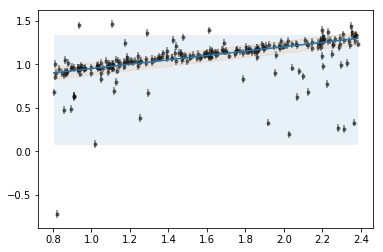

In [210]:
plt.errorbar(x, y, yerr=yerr, fmt = 'k.', alpha=.5, zorder=0)

xp = np.linspace(min(x), max(x), 100)
# Yb, Vb, Pb, V1, m, b
p_init = [.7, .4, .2, .005, .25, .7]
mean = line(p_init[4:], xp)
var = np.sqrt(p_init[1])
var1 = np.sqrt(p_init[3])
Yb = p_init[0]

plt.plot(xp, mean, zorder=1)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")
plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)

In [211]:
# Calculate maximum-likelihood values
nll = lambda *args: -lnlike(*args)
print(lnlike(p_init, x, y, yerr))
result = sco.minimize(nll, p_init, args=(x, y, yerr))
print(result.x)

412.8138226300547
[0.7   0.4   0.2   0.005 0.25  0.7  ]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


In [212]:
ndim, nwalkers = len(result.x), 32
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, yerr));
print("Burn-in")
pos, lp, state = sampler.run_mcmc(pos, 1000);
sampler.reset();
print("Full Run")
sampler.run_mcmc(pos, 5000);

Burn-in


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


Full Run


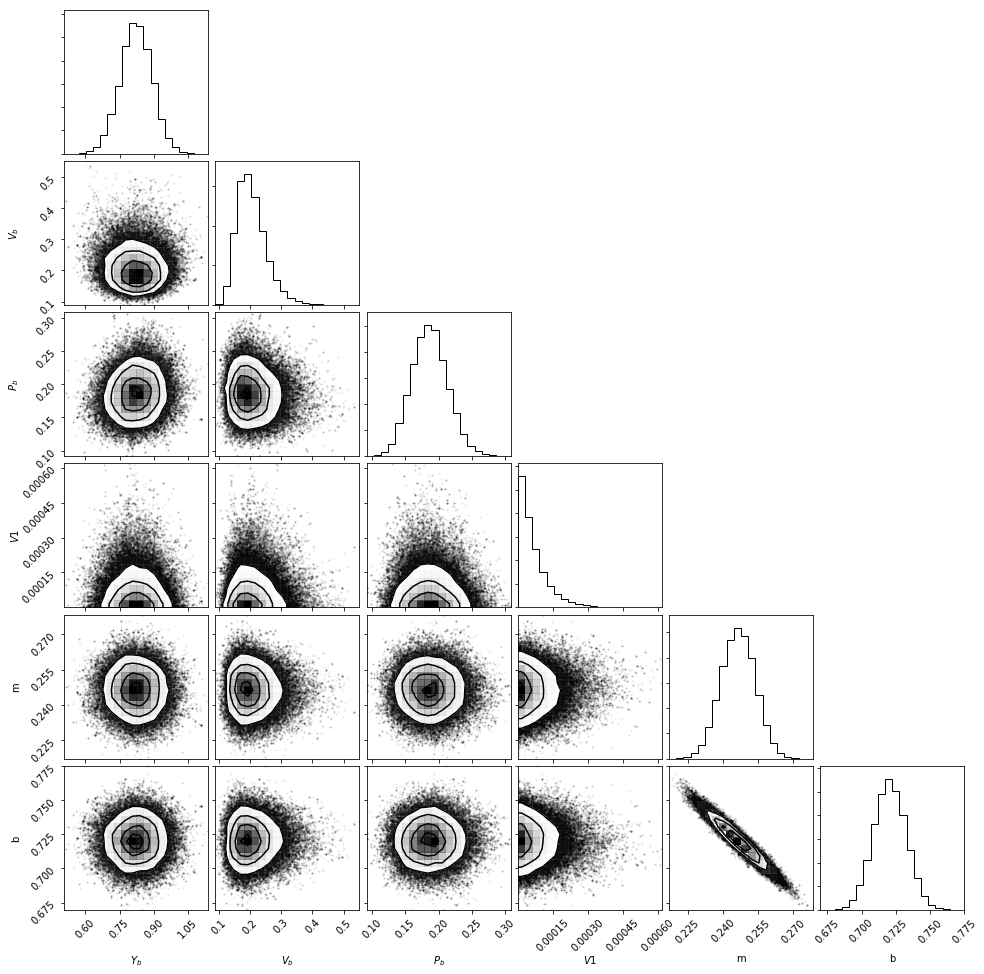

In [213]:
# Flatten chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# Make triangle plot
fig_labels = ["$Y_b$", "$V_b$", "$P_b$", "$V1$", "m", "b"]
# truths = [Yb_true, Vb_true, Pb_true, V1_true, m_true, b_true]
fig = corner.corner(samples, labels=fig_labels);

[8.21540332e-01 1.98212161e-01 1.85788198e-01 4.87033025e-05
 2.46469260e-01 7.20467705e-01]


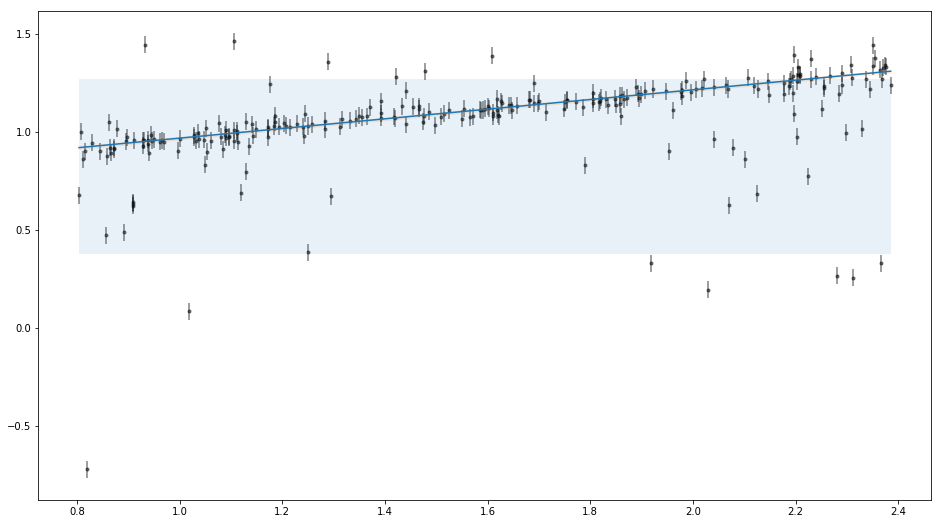

In [219]:

# Yb, Vb, Pb, V1, m, b
mcmc = np.median(samples, axis=0)
print(mcmc)

mean = line(mcmc[4:], xp)
var = np.sqrt(mcmc[1])
var1 = np.sqrt(mcmc[3])
Yb = mcmc[0]

plt.figure(figsize=(16, 9))
plt.errorbar(x, y, yerr=yerr, fmt = 'k.', alpha=.5, zorder=0)
plt.plot(xp, mean, zorder=1)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")
plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)

Now fit the M dwarfs

<ErrorbarContainer object of 3 artists>

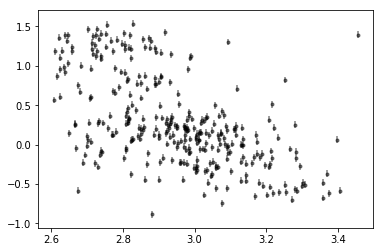

In [230]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0

bprp = pr.bp[m] - pr.rp[m]
logp = np.log10(pr.prot[m])

m = (bprp > 2.6) * np.isfinite(logp) * np.isfinite(bprp)
xm, ym = bprp[m], logp[m]

err = .434 * .1  # 10% uncertainty
yerrm = err * np.ones(len(xm))

plt.errorbar(xm, ym, yerr=yerrm, fmt = 'k.', alpha=.5, zorder=0)